In [ ]:
import numpy as np
import juliacall
jl_main = juliacall.Main
from scipy.special import softmax
from scipy.spatial import ConvexHull

glpde = jl_main.include("../src/GradientLimitPDE.jl")

In [ ]:
'''
geometry setting
'''
def remove_large_angle(node):
    angles_vec_ccw = np.roll(node, -1, axis=0) - node    # counterclockwise and clockwise  angle vector
    angles_vec_cc = np.roll(node, 1, axis=0) - node
    norm_ccw = np.linalg.norm(angles_vec_ccw, axis=1)
    norm_cc  = np.linalg.norm(angles_vec_cc, axis=1)     # Calculate the magnitudes of vectors and normlize vectors
    cos_theta = np.sum(angles_vec_ccw * angles_vec_cc, 
                        axis=1) / (norm_cc * norm_ccw)   # calculate cosine theta , dot product = norm_A * norm_B *cos_theta

    theta_rad = np.degrees(np.arccos(cos_theta))         # Calculate the angle between two vector
    node = node[theta_rad<170,:]
    return node

def node_angle_len(node):
    """
    每组点组成一个闭环，生成每个点处的角度值及其相临边的边长均值
    Args:
        node (array): 节点坐标
    Returns:
        edge_len(array):每条边的长度
        theta_rad(array , range in [0,360]): 每个角度的值，其中凹边对应的角大于180度,
                    数值在(0,360)间
    """
    edge_vec_1 = np.roll(node, -1, axis=0) - node # calculate edge vector and length, mean value of counterclockwise and clockwise
    edge_len_1 = np.sqrt(np.sum(edge_vec_1**2, axis=1))
    edge_vec_2 = np.roll(node, 1, axis=0) - node
    edge_len_2 = np.sqrt(np.sum(edge_vec_2**2, axis=1))
    edge_len = (edge_len_1 + edge_len_2) / 2
    
    angles_vec_ccw = np.roll(node, -1, axis=0) - node # counterclockwise and clockwise  angle vector
    angles_vec_cc = np.roll(node, 1, axis=0) - node
    norm_ccw = np.linalg.norm(angles_vec_ccw, axis=1) # Calculate the magnitudes of vectors and normlize vectors
    norm_cc  = np.linalg.norm(angles_vec_cc, axis=1)
    
    cos_theta = np.sum(angles_vec_ccw * angles_vec_cc,
                       axis=1) / (norm_cc * norm_ccw) # calculate cosine theta , dot product = norm_A * norm_B *cos_theta
    theta_rad = np.degrees(np.arccos(cos_theta))      # Calculate the angle between two vector
    # 判断夹角是否为凹角，如果是则转换为负值 .负数对应凹边的角，用360加去后得到大于180度的凹边角
    cross_product = np.cross(angles_vec_cc, angles_vec_ccw)
    theta_rad[cross_product > 0] = -theta_rad[cross_product > 0]
    theta_rad[theta_rad < 0] = 360 + theta_rad[theta_rad < 0]
    large_rad_index = np.argwhere(theta_rad > 170).squeeze() #r如果有大于170的则删去
    return theta_rad, edge_len, large_rad_index

def scale_to_target(arr, target_range=(0.095, 0.096)):
    """将权重数据缩放到指定空间
    Args:
        arr (array): 权重数据
        target_range (float, optional): 缩放到的空间指定值. Defaults to (0.05, 0.15).

    Returns:
        array: 缩放后的权重
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)  # 将数据缩放到[0, 1]范围
    # scaled_arr = np.sqrt(scaled_arr) # 使用平方根函数进行非线性缩放
    range_min, range_max = np.array(target_range)# /len(arr) # 缩放区间范围
    # scaled_arr = np.log(1+scaled_arr) * (range_max -range_min) + range_min  # 将数据缩放到目标范围
    scaled_arr = scaled_arr * (range_max -range_min) + range_min  # 将数据缩放到目标范围
    return scaled_arr

def geometry_spacing(geom_nodes):
    # node angle range in [0,pi];
    spacing_range=0.01
    node_angle=1/softmax(1/node_angle_len(geom_nodes)[0]) * softmax(node_angle_len(geom_nodes)[1]) #长边与小小角度获得较大的权重

    # 将权重缩放到指定空间
    spacing=scale_to_target(node_angle,target_range=(spacing_range,spacing_range)) 
    return spacing

def geometry_weights(geom_nodes):
    # node angle range in [0,pi];
    weights_range=0.5
    
    node_angle=softmax(1/node_angle_len(geom_nodes)[0]) # * softmax(node_angle_len(v)[1]) #长边与小小角度获得较大的权重

    # 将权重缩放到指定空间
    weights= scale_to_target(node_angle,target_range=(weights_range,weights_range))
                    
    return weights

def isNarrow(ps):
    '''
    #* 判断由ps构成的凸几何是否有很短的边
    '''
    edgeVec =  np.roll(ps, -1, axis=0) - ps 
    edgeLen =  np.sqrt(np.sum(edgeVec**2, axis=1))
    minEdgeLen = edgeLen.min()
    return True if minEdgeLen < edgeLen.mean()/5 else False

numPoints=np.random.randint(10,35)
xr,yr = np.random.randint(30,70)/100,np.random.randint(20,40)/100
xy=np.c_[xr*np.random.rand(numPoints)+(1-xr)/2,yr*np.random.rand(numPoints)+(1-yr)/2]
chull=ConvexHull(xy)

if not isNarrow(chull.points[chull.vertices]):
    inner=chull.points[chull.vertices] 
    inner = remove_large_angle(inner)
else:
    raise Exception('narrow geom')



In [ ]:
inner_nodes = inner

outer_edge_nodes_n = 2
outer_bottom = np.c_[np.linspace(0,1,outer_edge_nodes_n-1, endpoint=False),np.zeros(outer_edge_nodes_n-1)]
outer_right = np.c_[np.ones(outer_edge_nodes_n-1),np.linspace(0,1,outer_edge_nodes_n-1, endpoint=False)]
outer_top = np.c_[np.linspace(1,0,outer_edge_nodes_n-1, endpoint=False),np.ones(outer_edge_nodes_n-1)]
outer_left = np.c_[np.zeros(outer_edge_nodes_n-1),np.linspace(1,0,outer_edge_nodes_n-1, endpoint=False)]
outer_nodes = np.r_[outer_bottom,outer_right,outer_top,outer_left]
_,index = np.unique(outer_nodes,axis=0,return_index=True)
outer_nodes = outer_nodes[sorted(index),:]

inner_spacing = geometry_spacing(inner_nodes)
inner_nodal_psi = geometry_weights(inner_nodes)
inner_linear_psi = inner_nodal_psi

outer_spacing = np.ones(len(outer_nodes))
outer_nodal_psi= np.ones(len(outer_nodes))*0.25
outer_linear_psi= np.ones(len(outer_nodes))*0.25

In [ ]:

inner_boundary = glpde.Boundary(len(inner_nodes),inner_nodes,inner_spacing,inner_nodal_psi,inner_linear_psi)
outer_boundary = glpde.Boundary(len(outer_nodes),outer_nodes,outer_spacing,outer_nodal_psi,outer_linear_psi)
##* 均匀网格设置
background_grid = glpde.UniformSquareGrid([0., 0.], 1., 512, outer_spacing.mean())
##* 组装背景网格与边界
gradient_limit_pde = glpde.GradientLimitPDE(background_grid, jl_main.Vector([inner_boundary, outer_boundary]))
##* 求解
result = glpde.solve(gradient_limit_pde)
result = np.array(result).T

In [ ]:
gradient_limit_pde = glpde.GradientLimitPDE(background_grid, jl_main.Vector([inner_boundary, outer_boundary]))

In [7]:
result = glpde.solve(gradient_limit_pde)

In [8]:
result = np.array(result)
result

array([[0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.2       , 0.19640339, 0.19317788, ..., 0.18341885, 0.19015308,
        0.2       ],
       [0.2       , 0.19336143, 0.18833845, ..., 0.17125601, 0.1834176 ,
        0.2       ],
       ...,
       [0.2       , 0.18918418, 0.18077563, ..., 0.18408407, 0.19036127,
        0.2       ],
       [0.2       , 0.193849  , 0.18918348, ..., 0.19064565, 0.19440937,
        0.2       ],
       [0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ]])

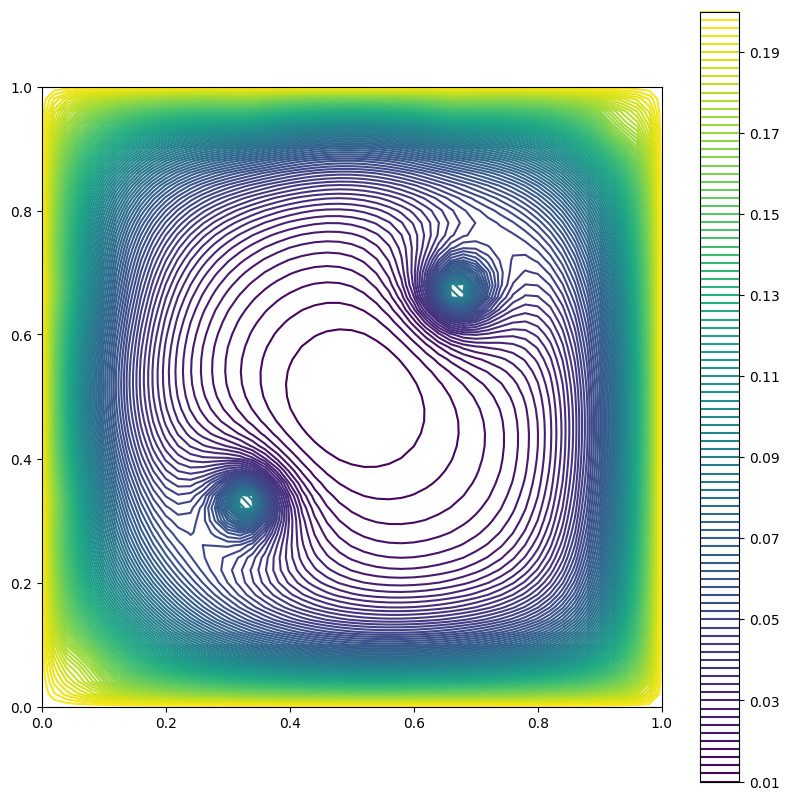

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10), facecolor='w')
plt.gca().set_aspect('equal')
plt.contour(background_grid.x_s, background_grid.y_s, result, 100)
plt.colorbar()
plt.show()